# **Analyzing Top 100 Billboard Song Lyrics**

## Introduction:
This project aims to derive insights into the themes and trends of the top 100 Billboard songs by analyzing their lyrics. By employing techniques such as web scraping, data processing, and visualization, the project sheds light on the lyrical landscape of popular music, bridging the gap between music and data analysis.

## **Workflow Breakdown**


### Step 1: Web Scraping Billboard Songs' Titles and Artists

Initially, the project utilizes Python libraries like requests and BeautifulSoup to extract essential information such as song titles and artists' names from the top 100 Billboard songs. This involves navigating through relevant websites to gather the necessary data for subsequent analysis.

### Step 2: Storing Song Details in SQL Database
Moving forward, the focus shifts to establishing a structured storage approach. By setting up an temperarly SQL database we minimizes redundant data retrieval, allowing more emphasis on processing new additions and analysis.

**Note:** At this stage, we're storing the Billboard 100 song details. We'll enrich the database with lyrics in the upcoming steps as we successfully retrieve them.

###Step 3: Extracting Lyrics through Web Scraping

Once the names of the songs and the names of the artists have been obtained, you can proceed to the next step. The project then employs advanced web scraping techniques to obtain song lyrics. By targeting specific websites known for hosting lyrics, it navigates their structures to extract the lyrics associated with each song. This process requires a deep understanding of the websites' data organization.

###Step 4: Text Preprocessing and Stop Word Removal
Once the lyrics are collected, the next step involves text preprocessing. This stage includes removing special characters, symbols, and unnecessary words that do not contribute significant meaning. The goal is to prepare the lyrics for more meaningful analysis.


### Step 5: Visualizing Most Frequent Words
To provide visual insights into the dominant themes, the project employs visualization libraries like matplotlib and WordCloud. This step generates graphical representations showcasing the most frequently occurring words in the lyrics, revealing prevalent topics and themes across the songs.


### **Important note: Data Usage and Ethics**

The project maintains a commitment to ethical data use procedures. This project minimizes the potential impact on external websites during web scraping and emphasizes adherence to legal and ethical standards. important to note that unauthorized data scraping is not approved. The information collected is used solely for private educational purposes and is not used for commercial purposes and it is deleted after use.

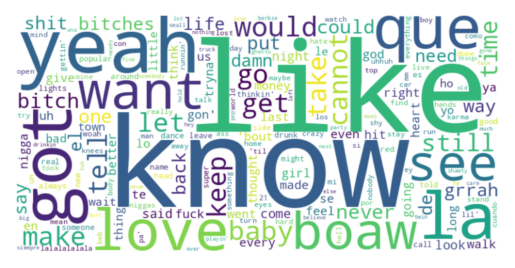

In [ ]:
!pip install contractions
from contractions import fix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 5.6 MB/s eta 0:00:00


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import sqlite3
import time
import random

In [ ]:
def get_billboard_response() -> str:
    """
    Retrieves the HTML content of the Billboard Hot 100 chart page.
    """
    url = "https://www.billboard.com/charts/hot-100"
    response = requests.get(url)
    if response.status_code == 200:
        # Successful request
        html_content = response.content
    else:
        # Handle error cases
        print(f"Request failed with status code {response.status_code}")
        html_content = None
    return html_content


def get_titles_singers(soup: BeautifulSoup) -> tuple:
    """
    Extracts song titles and singer names from the provided BeautifulSoup object.
    """
    song_titles_html = soup.find_all('li' > 'h3',id="title-of-a-story",  class_=re.compile("c-title a-no-trucate"))
    singer_names_html = [song.find_next_sibling('span') for song in song_titles_html]

    song_titles, singer_names = [], []
    for title, singer in zip(song_titles_html, singer_names_html):
        song_titles.append(title.get_text(strip=True))
        singer_names.append(singer.get_text(strip=True))
    return song_titles, singer_names



def get_billboard_data() -> tuple:
    """
    Retrieves Billboard Hot 100 song data (song titles and singer names).
    """

    html_content = get_billboard_response()
    if html_content:
      soup = BeautifulSoup(html_content, 'html.parser')
      song_titles, singer_names = get_titles_singers(soup)
      return song_titles, singer_names
    else:
        return [], []


In [ ]:
def count_songs_with_lyrics() -> int:
    """
    Counts the number of songs with lyrics in the database.
    """
    db_cursor, db_connection = connect_to_songs_db()

    db_cursor.execute('SELECT COUNT(*) FROM songs WHERE lyrics IS NOT NULL')
    count = db_cursor.fetchone()[0]

    db_connection.close()
    return count

#connect_to_database
def connect_to_songs_db():
    db_connection = sqlite3.connect('songs_database.db')
    db_cursor = db_connection.cursor()
    return db_cursor, db_connection

def check_song_exists(cursor, title, artist):
    cursor.execute("SELECT * FROM songs WHERE title=? AND artist=?", (title, artist))
    return cursor.fetchone()

def insert_song(cursor, db_connection, title, artist, lyrics=None, vocabulary=None):
    cursor.execute("INSERT INTO songs (title, artist, lyrics, vocabulary) VALUES (?, ?, ?, ?)", (title, artist, lyrics ,vocabulary))
    db_connection.commit()

def insert_lyrics(cursor, db_connection, song_title, lyrics, vocabulary):
    if vocabulary==None:
      vocabulary_str = None
    else:
      vocabulary_str = ",".join(vocabulary)
    cursor.execute("UPDATE songs SET lyrics=?, vocabulary=? WHERE title=?", (lyrics, vocabulary_str, song_title))
    db_connection.commit()

def remove_non_listed_songs(cursor, db_connection, song_titles):
    placeholders = ", ".join(["?"] * len(song_titles))
    cursor.execute(f"DELETE FROM songs WHERE title NOT IN ({placeholders})", song_titles)
    db_connection.commit()

#initialize_songs_db()
def initialize_songs_table(db_cursor, db_connection):
    # Create a table to store song information
    db_cursor.execute('''
        CREATE TABLE IF NOT EXISTS songs (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            title TEXT,
            artist TEXT,
            lyrics TEXT,
            vocabulary TEXT
        )
    ''')
    db_connection.commit()


def db_update(titles, artists):
    db_cursor, db_connection = connect_to_songs_db()
    initialize_songs_table(db_cursor, db_connection)
    for title, artist in zip(titles, artists):
        existing_song = check_song_exists(db_cursor, title, artist)
        if existing_song:
            pass
        else:
            insert_song(db_cursor, db_connection, title, artist)

    remove_non_listed_songs(db_cursor, db_connection, titles)

    db_cursor.close()
    db_connection.close()

def db_get_data(db_cursor):
    db_cursor.execute(f"SELECT * FROM songs")
    return db_cursor.fetchall()

In [ ]:
def get_song_id_by_title(title):
    conn = sqlite3.connect('songs_database.db')
    cursor = conn.cursor()
    cursor.execute("SELECT id FROM songs WHERE title = ?", (title,))
    row = cursor.fetchone()
    conn.close()
    return row[0] if row else None

def store_error_in_errors_db(db_cursor, title, artist, error_message, html_content, website):
    song_id = get_song_id_by_title(title)
    if website == 'letrasboom':
        db_cursor.execute("INSERT INTO errors (song_id, title, artist, error_message_letrasboom, html_content_letrasboom) VALUES (?, ?, ?, ?, ?)",
                      (song_id, title, artist, error_message, html_content))
    elif website == 'letras':
        db_cursor.execute("INSERT INTO errors (song_id, title, artist, error_message_letras, html_content_letras) VALUES (?, ?, ?, ?, ?)",
                      (song_id, title, artist, error_message, html_content))

def remove_error_from_errors_db(db_cursor, db_connection, title):
    db_cursor.execute("DELETE FROM errors WHERE title = ?", (title,))
    db_connection.commit()

def initialize_errors_db(db_cursor, db_connection):
    # Create errors table
    db_cursor.execute('''
        CREATE TABLE IF NOT EXISTS errors (
            song_id INTEGER,
            title TEXT,
            artist TEXT,
            error_message_letrasboom TEXT,
            html_content_letrasboom TEXT,
            error_message_letras TEXT,
            html_content_letras TEXT
        )
    ''')

    db_connection.commit()

def print_data(table_name, song_id=None, song_title=None):
    # Define the path to your SQLite database
    db_songs_path = '/content/songs_database.db'

    # Connect to the database
    conn = sqlite3.connect(db_songs_path)

    # Define your SQL query to fetch data from the database
    if song_id is not None:
        query = f"SELECT * FROM {table_name} WHERE id = {song_id}"
    elif song_title is not None:
        query = f"SELECT * FROM {table_name} WHERE title = '{song_title}'"
    else:
        query = f"SELECT * FROM {table_name}"

    # Fetch data using pandas
    data = pd.read_sql(query, conn)

    # Display the data
    display(data)

    # Close the database connection
    conn.close()

In [ ]:
def clean_lyrics(lyrics):
    #Remove Words Inside Square Brackets
    cleaned_lyrics = re.sub(r'\[.*?\]', '', lyrics)

    cleaned_lyrics = cleaned_lyrics.replace("\n", ' ')

    #Remove Non-Alphanumeric Characters (Except Spaces)
    cleaned_lyrics = re.sub(r'[^a-zA-Z0-9\s\']', '', cleaned_lyrics)
    cleaned_lyrics = cleaned_lyrics.lower()

    return cleaned_lyrics

def lyrics_formatter(lyrics):

    #NLTK's list of english stopwords
    #took out: 'i', 'you'.    insert: 'oh', 'ooh' ,'ayy', 'ah', 'mm'.
    step_words = "ayy ah oh ooh me my myself we our ours ourselves youre youve youll youd your yours yourself yourselves he him his himself she shes her hers herself it its its itself they them their theirs themselves what which who whom this that thatll these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don dont should shouldve now d ll m o re ve y ain aren arent couldn couldnt didn didnt doesn doesnt hadn hadnt hasn hasnt haven havent isn isnt ma mightn mightnt mustn mustnt needn neednt shan shant shouldn shouldnt wasn wasnt weren werent won wont wouldn wouldnt"
    step_words = step_words.split()

    words_list = lyrics.split(' ')
    # expand contractions like "it's" to "it is."
    words_list = [fix(word) for word in words_list]
    # remove all empty string elements and expand contractions for two diffrent words
    words_list = [word for item in words_list for word in item.split() if word and word not in step_words ]
    return words_list

def extract_vocabulary(lyrics):
    lyrics = clean_lyrics(lyrics)
    words_list = lyrics_formatter(lyrics)
    return words_list


def artist_format_for_letras(artist): #check if needed for letras as alternative
    artist = artist.split()
    if len(artist) > 1 and artist[1] in ['X', '&', 'Featuring']:
     return artist[0].lower()
    else:
      artist = artist[:2]
      artist = '-'.join(artist)
      pattern = r'[^a-zA-Z0-9-]+'
      return re.sub(pattern, '', artist).lower()

def title_clean_and_format_letras(input_str):
    input_str = input_str.replace('&','e')
    input_str = input_str.replace(' ','-')
    input_str = input_str.replace('!','-')
    pattern = r'[^a-zA-Z0-9-]+'
    return re.sub(pattern, '', input_str)

def artist_clean_and_format(artist):
    artist = artist.split()
    if len(artist) > 1 and artist[1] in ['X', '&', 'Featuring']:
     artist = artist[0]
    else:
      artist = '-'.join(artist[:2])
    pattern = r'[^a-zA-Z0-9-]+'
    return re.sub(pattern, '', artist).lower()

def title_clean_and_format(input_str):
    pattern = r'[^a-zA-Z0-9]+'
    return re.sub(pattern, ' ', input_str).strip().lower().replace(' ', '-')

def get_url(title, artist, website='letrasboom'):
    if website == 'letrasboom':
       artist_f  = artist_clean_and_format(artist)
       title_f = title_clean_and_format(title)
       url = f"https://www.letrasboom.com/letra/{title_f}-{artist_f}"

    elif website == 'letras':
       artist_f  = artist_format_for_letras(artist)
       title_f = title_clean_and_format_letras(title)
       url = f"https://www.letras.com/{artist_f}/{title_f}"
    else:
      url = None
    return url


def get_lyrics_html(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors (4xx, 5xx)
        html_content = response.content
        return html_content, None
    except requests.exceptions.RequestException as e:
        # Handle request exceptions (connection errors, timeouts, etc.)
        return None, str(e)

def extract_lyrics_data(html_content, website='letrasboom'):
    soup = BeautifulSoup(html_content, 'html.parser')

    if website == 'allthelyrics':
      selector = 'div > div.content-text-inner'

    elif  website == 'letras':
      selector = 'div.lyric-original > p'

    elif website == 'letrasboom':
      selector = 'div > div.lyricbody > p'

    result = soup.select(selector)
    if result:
        result = ' '.join([p.get_text() for p in result])
    else:
        print("Element not found.")
        result = None
    return result


def fetch_lyrics_with_web_scraping(title, artist):
    db_cursor, db_connection = connect_to_songs_db()
    initialize_errors_db(db_cursor, db_connection)
    for website in ['letrasboom', 'letras']:
        url = get_url(title, artist, website)
        html_content, eror = get_lyrics_html(url)

        if eror:
          store_error_in_errors_db(db_cursor, title, artist, str(eror), None, website)
        else:
          # no eror found
          lyrics_data = extract_lyrics_data(html_content, website)

          if lyrics_data:
            db_connection.rollback()
            remove_error_from_errors_db(db_cursor, db_connection, title)
            vocabulary = extract_vocabulary(lyrics_data)
            db_cursor.close()
            return vocabulary, lyrics_data

          else:
            #no eror but html suspicios data
            store_error_in_errors_db(db_cursor, title, artist, None, html_content, website)

    print(f"No results found for '{title}' by {artist}.")
    db_connection.commit()
    db_connection.close()
    return None, None

def db_update_lyrics(N = None):
    db_cursor, db_connection = connect_to_songs_db()

    data = db_get_data(db_cursor)

    min_delay = 3  # Minimum delay in seconds
    max_delay = 30  # Maximum delay in seconds

    for songs_id, title, artist, lyrics, vocabulary in data:
        if lyrics:
            continue
        else:
            if  N == 0:
                  break  # Stop after N searches
            elif N is not None:
                N-=1
            print(f'extracting: {songs_id}, {title}')
            vocabulary, lyrics = fetch_lyrics_with_web_scraping(title, artist)
            if lyrics:
              insert_lyrics(db_cursor, db_connection, title, lyrics, vocabulary)

            # Generate a random delay between min_delay and max_delay
            delay = random.uniform(min_delay, max_delay)
            time.sleep(delay)  # Add a random delay before the next request

    db_cursor.close()
    db_connection.close()

def db_update_lyrics_manually_by_url(data): # data = [(title, artist, website, url)]

    db_cursor, db_connection = connect_to_songs_db()
    min_delay = 3  # Minimum delay in seconds
    max_delay = 30  # Maximum delay in seconds
    for title, artist, website, url in data:
      print(f'extracting:  {title}')
      html_content, eror = get_lyrics_html(url)
      lyrics_data = extract_lyrics_data(html_content, website)
      if lyrics_data:
        vocabulary = extract_vocabulary(lyrics_data)
      else:
        #no eror but html suspicios data
        print(f'{title}, {artist}, {website}, suspicios HTML file')


      insert_lyrics(db_cursor, db_connection, title, lyrics_data, vocabulary)

      # Generate a random delay between min_delay and max_delay
      delay = random.uniform(min_delay, max_delay)
      time.sleep(delay)  # Add a random delay before the next request

    db_cursor.close()
    db_connection.close()

In [ ]:
if __name__ == "__main__":
    song_titles, singer_names = get_billboard_data()
    db_update(song_titles, singer_names)



In [ ]:
if __name__ == "__main__":
    song_titles, singer_names = get_billboard_data()
    db_update(song_titles, singer_names)
    db_update_lyrics()


In [ ]:
if __name__ == "__main__":
    db_update_lyrics() #number of lyrics to extract, empty to get all the songs


extracting: 79, Johnny Dang
No results found for 'Johnny Dang' by That Mexican OT, Paul Wall & DRODi.


In [ ]:
def remove_errors_table():
    # Connect to the database
    db_cursor, db_connection = connect_to_songs_db()


    # Drop the "errors" table if it exists
    db_cursor.execute('''
        DROP TABLE IF EXISTS errors
    ''')

    # Commit the changes and close the connection
    db_connection.commit()
    db_connection.close()
remove_errors_table()

In [ ]:
print(f'found {count_songs_with_lyrics()} lyrics out of 100')

found 98 lyrics out of 100


In [ ]:
print_data('songs')

,id,title,artist,lyrics,vocabulary
0,1,Last Night,Morgan Wallen,"Last night, we let the liquor talk I can't rem...","last,night,let,liquor,talk,i,cannot,remember,e..."
1,2,Fast Car,Luke Combs,You got a fast car And I want a ticket to anyw...,"you,got,fast,car,i,want,ticket,anywhere,maybe,..."
2,3,Cruel Summer,Taylor Swift,"(Yeah, yeah, yeah, yeah) Fever dream high i...","yeah,yeah,yeah,yeah,fever,dream,high,quiet,nig..."
3,4,Calm Down,Rema & Selena Gomez,"(Vibez) Another banger Baby, calm down, calm d...","vibez,another,banger,baby,calm,calm,girl,body,..."
4,5,Fukumean,Gunna,"(Ooh, Dunk Rock) Fuck you mean? Young Gunna Wu...","dunk,rock,fuck,you,mean,young,gunna,wunna,back..."
...,...,...,...,...,...
95,96,Lagunas,Peso Pluma & Jasiel Nunez,"Esta noche hay luna llena, cargo energías buen...","esta,noche,hay,luna,llena,cargo,energas,buenas..."
96,97,Overdrive,Post Malone,I spend my nights on overdrive I live my life ...,"i,spend,nights,overdrive,i,live,life,overtired..."
97,98,"Bzrp Music Sessions, Vol. 55",Bizarrap & Peso Pluma,"Ey, yeahThis is the Big OneWhat up?Ey, suena, ...","ey,yeahthis,big,onewhat,upey,suena,yeahah,ey,d..."
98,99,Dawns,Zach Bryan Featuring Maggie Rogers,Mm Mm (Ooh) Wake me up when the season's gone ...,"mm,mm,wake,season's,gone,i,wasted,dawns,you,i,..."


In [ ]:
print_data('songs', song_id=92)

,id,title,artist,lyrics,vocabulary
0,92,Skitzo,Travis Scott Featuring Young Thug,"Be me, I move at night when they really can't ...","i,move,night,really,cannot,see,mei,ran,back,la..."


In [ ]:
print_data('songs', song_title='Good Good')

,id,title,artist,lyrics,vocabulary
0,68,Good Good,"Usher, Summer Walker & 21 Savage","We Are All Just Aching, We're Waiting, For Hea...","aching,waiting,heartbreak,world,light,darkness..."


In [ ]:
print_data('errors')

,id,song_id,title,artist,error_message_letrasboom,html_content_letrasboom,error_message_letras,html_content_letras
0,1,76,Fragil,Yahritza y Su Esencia x Grupo Frontera,404 Client Error: Not Found for url: https://w...,None,None,None
1,2,76,Fragil,Yahritza y Su Esencia x Grupo Frontera,None,None,404 Client Error: Not Found for url: https://w...,None
2,3,79,Johnny Dang,"That Mexican OT, Paul Wall & DRODi",404 Client Error: Not Found for url: https://w...,None,None,None
3,4,79,Johnny Dang,"That Mexican OT, Paul Wall & DRODi",None,None,404 Client Error: Not Found for url: https://w...,None


In [ ]:
data = [('Fragil', 'Yahritza y Su Esencia x Grupo Frontera','letras', 'https://www.letras.com/yaritza-martinez/fragil-part-grupo-frontera/')]
db_update_lyrics_manually_by_url(data)  # data = [(title, artist, website, url),]

extracting:  Fragil


In [ ]:
print(f'found {count_songs_with_lyrics()} lyrics out of 100')

found 99 lyrics out of 100


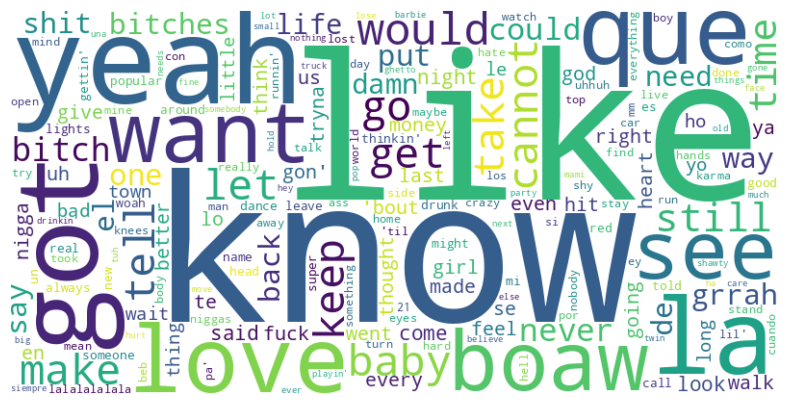

In [ ]:
import collections
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# List of words to exclude from the word cloud
words_to_exclude = ["i", "you",'ayy', 'ah']

def generate_wordcloud(data):
    freq_words = collections.Counter()

    # Iterate through the data and accumulate word frequencies
    for _, _, _, _, vocabulary_str in data:
        if vocabulary_str:
          vocabulary = vocabulary_str.split(',')
          freq_words.update(vocabulary)

    # Filter out words to exclude from the word cloud
    for word in words_to_exclude:
        if word in freq_words:
            del freq_words[word]

    # Plot the final word cloud
    plot_wordcloud(freq_words)

def plot_wordcloud(word_counter):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)
    plt.figure(figsize=(10, 5))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def plot_data():
    db_cursor, db_connection = connect_to_songs_db()
    data = db_get_data(db_cursor)

    generate_wordcloud(data)
    db_connection. close()

plot_data()


# Analyzing the data the data
check for wierd words like: se, te le, lo, es, pa, la

In [ ]:
def get_lyrics_by_title(title):
    db_cursor, db_connection = connect_to_songs_db()
    db_cursor.execute("SELECT lyrics FROM songs WHERE title=?", (title,))
    result = db_cursor.fetchone()
    db_cursor.close()
    if result:
        return result[0]
    else:
        return "Lyrics not found for this title."

def search_words_in_songs(words):
    results = {}
    db_cursor, db_connection = connect_to_songs_db()
    for word in words:
        formatted_word = f",{word},"
        db_cursor.execute("SELECT title FROM songs WHERE vocabulary LIKE ?", ('%' + formatted_word + '%',))
        matching_songs = db_cursor.fetchall()
        results[word] = [song[0] for song in matching_songs]
    db_connection.close()
    return results

In [ ]:
search_words = ['se', 'te', 'le', 'lo', 'es', 'pa', 'la', 'mm']
word_song_mapping = search_words_in_songs(search_words)

for word, songs in word_song_mapping.items():
    print(f"Songs containing '{word}': {', '.join(songs) or 'No matching songs'}")

Songs containing 'se': Ella Baila Sola, La Bebe, LaLa, Lady Gaga, Where She Goes, Sabor Fresa, Tulum, Fragil, El Amor de Su Vida, Lagunas, Rubicon
Songs containing 'te': K-POP, Ella Baila Sola, La Bebe, Un x100to, LaLa, Lady Gaga, Where She Goes, Tulum, Fragil, Bzrp Music Sessions, Vol. 55, Rubicon
Songs containing 'le': K-POP, Ella Baila Sola, La Bebe, LaLa, Lady Gaga, Where She Goes, Sabor Fresa, Tulum, TQM, El Amor de Su Vida
Songs containing 'lo': K-POP, La Bebe, Put It On Da Floor Again, Un x100to, LaLa, Where She Goes, Tulum, Fragil, El Amor de Su Vida, Lagunas, Bzrp Music Sessions, Vol. 55
Songs containing 'es': K-POP, La Bebe, Un x100to, LaLa, Lady Gaga, Where She Goes, Sabor Fresa, Tulum, Fragil, El Amor de Su Vida, Lagunas, Rubicon
Songs containing 'pa': No matching songs
Songs containing 'la': Barbie World, Cupid, K-POP, Ella Baila Sola, La Bebe, Put It On Da Floor Again, Un x100to, LaLa, Lady Gaga, Where She Goes, Sabor Fresa, Tulum, TQM, God's Country, Lagunas, Rubicon
Son

In [ ]:
print(get_lyrics_by_title('K-POP'))


Gonna pop, baby Vemo' Swish, lit (Lit) Move that shit out here (Here) You full off one sip (Sip) Fallin' off but I got grip (Grip) All around the trap, it hit (Hit, hit, ayy) All around the map, you trip (Skrrt) Take it like nine out of ten (Yeah) Think they gon' find that again Think I gotta bond out again Behind the tint, I sin, I vent Can't forget about that place we went Right after you put that in my head Do you still pop 'em? Do you dance? Do you still drop some'? Know you can I got a lot but I'm still chancin' Yeah-yeah, yeah, yeah Hace tiempo no te veo, eh Es que ahora en Miami jangueo, eh, eh Ya no tengo la Rodeo Ahora en la G-Wagon me spoteo, ey Y te lo meto al frente 'e la playa Como aquello' tiempo' de camino a Maya Tú ni fumaba' y chingando te arrebaté Dale, no pierdas tiempo, no lo piense', trépate Tú bien loca, loca, yo bien loco, loco Si ahora tu mai nos pilla, me pide una foto La nota me explota, el ticke' lo exploto Vamo' pa' Cayo Musha, ya le texteé al piloto, eh-eh 


All words in the text are valid, except 'mm,' which is not a real word but a vocalized sound like a hum. So, when counting words, exclude 'mm' as it lacks meaningful linguistic content.

In [ ]:
!pip install bar_chart_race

In [ ]:
import collections
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import bar_chart_race as bcr

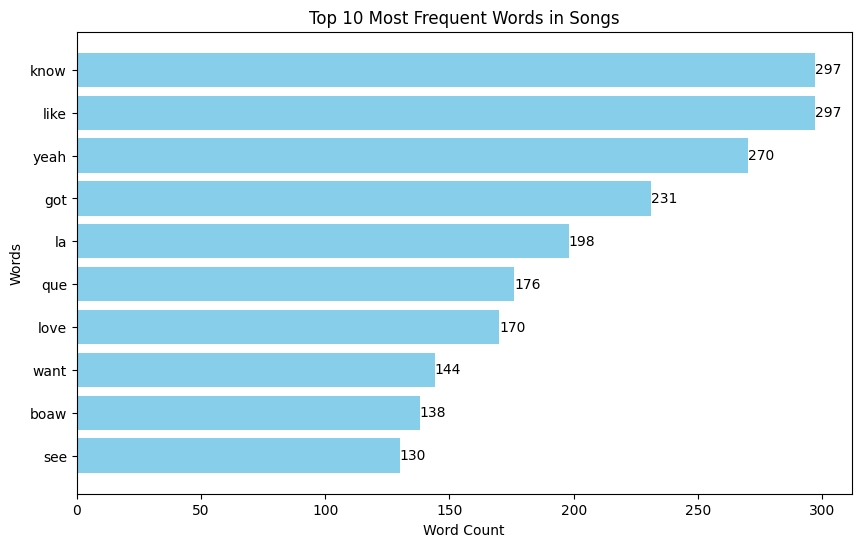

In [ ]:
# List of words to exclude from the word cloud
words_to_exclude = ["i", "you", "ayy", "ah"]

def generate_word_frequencies(data):
    freq_words = collections.Counter()

    # Iterate through the data and accumulate word frequencies
    for _, _, _, _, vocabulary_str in data:
        if vocabulary_str:
            vocabulary = vocabulary_str.split(',')
            freq_words.update(vocabulary)

    # Filter out words to exclude
    for word in words_to_exclude:
        if word in freq_words:
            del freq_words[word]

    return freq_words

def plot_frequent_words_bar_chart(word_counter):
    most_common_words = word_counter.most_common(10)
    words, counts = zip(*most_common_words)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(words, counts, color='skyblue')
    plt.xlabel('Word Count')
    plt.ylabel('Words')
    plt.title('Top 10 Most Frequent Words in Songs')

    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(bar.get_width()), va='center')

    plt.gca().invert_yaxis()
    plt.show()

def main():
    db_cursor, db_connection = connect_to_songs_db()
    data = db_get_data(db_cursor)

    word_frequencies = generate_word_frequencies(data)
    plot_frequent_words_bar_chart(word_frequencies)

if __name__ == "__main__":
    main()


In [ ]:
def get_cumulative_freq_words_pd(excluded_words=[]):
    db_cursor, db_connection = connect_to_songs_db()
    data = db_get_data(db_cursor)

    cumulative_word_counts = collections.Counter()

    dfs = []  # List to store DataFrames before concatenation
    titles = []  # List to store titles for DataFrame index

    for _, title, _, _, vocabulary_str in data:
        if vocabulary_str:
            vocabulary = vocabulary_str.split(',')

            # Exclude words from the vocabulary
            filtered_vocabulary = [word for word in vocabulary if word not in excluded_words]

            song_word_counts = collections.Counter(filtered_vocabulary)

            cumulative_word_counts += song_word_counts
            titles.append(title)  # Store title for index later

            # Append a copy of the cumulative_word_counts to the list of DataFrames
            dfs.append(cumulative_word_counts.copy())

    # Create a DataFrame from the list of cumulative word counts
    result_df = pd.DataFrame(dfs, index=titles).fillna(0)

    db_connection.close()

    return result_df


def bar_chart_race_gen():
    words_to_exclude = ['i', 'you']
    cumulative_word_frequencies = get_cumulative_freq_words_pd(words_to_exclude)

    # Create an animated bar chart race
    bcr.bar_chart_race(
        cumulative_word_frequencies,
        filename='bar_chart_race.mp4',
        title="Word Frequencies in Billboard Top 100 Songs",
        n_bars=10,
        steps_per_period=10,
        period_length=50,
        filter_column_colors=True  # Filter column colors to reduce repetition
    )
bar_chart_race_gen()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/bar_chart_race/_make_chart.py:284: UserWarning: Glyph 2115 (\N{MANDAIC LETTER AD}) missing from current font.
  fig.canvas.print_figure(io.BytesIO())
/usr/local/lib/python3.10/dist-packages/bar_chart_race/_make_chart.py:284: UserWarning: Glyph 2116 (\N{MANDAIC LETTER AH}) missing from current font.
  fig.canvas.print_figure(io.BytesIO())
/usr/local/lib/python3.10/dist-packages/bar_chart_race/_make_chart.py:284: UserWarning: Glyph 2117 (\N{MANDAIC LETTER USHENNA}) missing from current font.
  fig.canvas.print_figure(io.BytesIO())
/usr/local/lib/python3.10/dist-packages/bar_chart_race/_make_chart.py:284: UserWarning: Glyph 2118 (\N{MANDAIC LETTER AZ}) missing from current font.
  fig.canvas.print_figure(io.BytesIO())
/usr/local/lib/python3.10/dist-packages/bar_chart_race/_make_chart.py:284: UserWarning: Glyph 2119 (\N{MANDAIC LETTER IT}) missing from current font.
  fig.canvas.print_figure(io.Bytes

# testing diffrent url

In [ ]:
#bot ditection:
#url = 'https://www.azlyrics.com/lyrics/sza/snooze.html'


#not Working:

# seldom:
# url  = "https://www.allthelyrics.com/lyrics/taylor_swift-cruel_summer"

#often
url = 'https://www.letras.com/taylor-swift/cruel-summer/'

url = 'https://www.letrasboom.com/letra/overdrive-post-malone'


#working:

response = requests.get(url)

if response.status_code == 200:
    print('Successful request')
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')
else:
    # Handle error cases
    print(f"Request failed with status code {response.status_code}, song ")


Successful request


# testing html css

In [ ]:
with open('html_content_testing.html', 'rb') as file:
    html_content_test = file.read()
    soup = BeautifulSoup(html_content_test, 'html.parser')

    print(soup.find('li', class_='mainmenuli-open').prettify())
    print('- *'*7)
    selector = "li.mainmenuli-open > ul > li.mainmenulili , li.mainmenuli-open > a" #two objects
    a = soup.select(selector)
    print(a)

<li class="mainmenuli mainmenuli-open mainmenuli-active" id="mainmenuli">
 <a href="/">
  Lyrics
 </a>
 <ul class="mainmenuulul">
  <li class="mainmenulili">
   <a href="https://www.allthelyrics.com/forum/">
    Forum
   </a>
  </li>
  <!-- <li class="mainmenulili nomobile"><a href="https://www.allthelyrics.com/forum/activity.php">What&#039;s New?</a></li> -->
  <li class="mainmenulili">
   <a href="/index">
    A-Z Artists
   </a>
  </li>
 </ul>
</li>

- *- *- *- *- *- *- *
[<a href="/">Lyrics</a>, <li class="mainmenulili"><a href="https://www.allthelyrics.com/forum/">Forum</a></li>, <li class="mainmenulili"><a href="/index">A-Z Artists</a></li>]
